<a href="https://colab.research.google.com/github/EmilijaSvirsk/DeepLearning-CustomModel/blob/main/2lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2 lab ;
Emilija Svirskytė 2gr ;
klasės - bee, ice cream, mushroom

#Antras laboratorinis
Antroje užduotyje reikia realizuoti vaizdų klasifikavimo modelį. Atsiskaitinėjant pratybų dėstytojas atsiųs testinių vaizdų, su kuriais turėsite pademonstruoti, kaip jūsų realizuotas modelis veikia. Atsiskaitymo metu, turėsite gebėti papasakoti, kaip realizuotas, jūsų modelis. Programinės įrangos sprendimą galite naudoti savo nuožiūra.

*   Klasės pasirenkamos savo nuožiūra, tačiau jų turi būti bent 3.
*   Duomenų rinkinys turi būti padalintas į mokymo ir testavimo aibes.
*   Su testavimo duomenų aibe reikia paskaičiuoti šias metrikas: klasifikavimo matrica (angl. confusion matrix), tikslumas, precizija, atkūrimas ir F1.

Duomenų klasėms parinktos iš OpenImages V6 objektų aptikimo uždavinio duomenų rinkinio.

In [ ]:
from datetime import datetime
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:0


##Transformacijos

In [ ]:
#validavimo transformacijos
transforms_valid = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
#treneravimo transformacijos
transforms_train = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness = 0.4, saturation = 0.1, hue = 0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

##Datasets

In [ ]:
#sukuriam databases
data_dir_train = "drive/MyDrive/GMM_images/train/data"
data_dir_valid = "drive/MyDrive/GMM_images/valid/data"

train_dataset = torchvision.datasets.ImageFolder(data_dir_train, transform = transforms_train)
valid_dataset = torchvision.datasets.ImageFolder(data_dir_valid, transform = transforms_valid)

num_workers = 2
batch_size = 25

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

print(f'Train: {len(train_dataset)}, Test: {len(valid_dataset)}')

Train: 150, Test: 150


##Modelis

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ConvNet, self).__init__()
        self.num_classes = num_classes

        # 3 input image channels, 6 output channels, 3x3 square convolution
        self.conv1 = torch.nn.Conv2d(input_shape[0], 6, 3,padding = 'same')
        self.conv2 = torch.nn.Conv2d(6, 16, 3,padding = 'same')

        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)

        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16*(input_shape[1] // 4) * (input_shape[2] // 4), 120)
        self.fc2 = torch.nn.Linear(120, num_classes)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        #conv + pool
        x = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv1(x)), 2)
        x = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv2(x)), 2)

        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension

        x = self.dropout1(x)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [ ]:
model = ConvNet(train_dataset[0][0].shape, 3).to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=3, bias=True)
)


##Mokymo ir testavimo funkcijos

Su testavimo duomenų aibe reikia paskaičiuoti šias metrikas: klasifikavimo matrica (angl. confusion matrix), tikslumas, precizija, atkūrimas ir F1.

In [ ]:
class Statistics():
  def __init__(self):
    self.classes = ['bee','ice cream','mushroom']
    self.pred_arr = []
    self.label_arr = []

  def addResultsArray(self, label_arr, pred_arr):
    self.pred_arr = np.concatenate((self.pred_arr,pred_arr), axis=None)
    self.label_arr = np.concatenate((self.label_arr,label_arr), axis=None)

  def getConfusionMatrixDataFrame(self):
    return pd.DataFrame(confusion_matrix(self.label_arr,self.pred_arr),
                     self.classes,
                     self.classes)

  def getClassConfusionMatrix(self, label):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(self.pred_arr)):
      true_result = self.label_arr[i]
      prob_result = self.pred_arr[i]
      #TP obj exists and model found it
      if((true_result==prob_result) and (prob_result==label)):
        TP+=1
      #TN obj doesnt exist and model didnt find it
      elif((true_result!=prob_result) and (true_result!=label) and (prob_result!=label)):
        TN+=1
      #FP obj exists but model didnt find it
      elif((true_result!=prob_result) and (true_result==label)):
        FP+=1
      #FN obj doesnt exist but model found it
      elif((true_result!=prob_result) and (prob_result==label)):
        FN+=1
    return {"TP":TP,"TN":TN,"FP":FP,"FN":FN}

  def getStatistics(self, matrix):
    TP = matrix['TP']
    TN = matrix['TN']
    FP = matrix['FP']
    FN = matrix['FN']
    stats = {}

    if((TP + FP + TN + FN)==0):
      stats['accuracy'] = 0
    else:
      stats['accuracy'] = (TP + TN) / (TP + FP + TN + FN)
    if((TP + FN)==0):
      stats['recall'] = 0
    else:
      stats['recall'] = TP / (TP + FN)
    if((TP + FP)==0):
      stats['precision'] = 0
    else:
      stats['precision'] = TP / (TP + FP)
    if((stats['precision'] + stats['recall'])==0):
      stats['f1'] = 0
    else:
      stats['f1'] = 2 * (stats['precision'] * stats['recall']) / (stats['precision'] + stats['recall'])

    return stats


In [ ]:
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [ ]:
def train_epoch(optimizer, loss_func, model, loader):
  num_classes = model.num_classes
  #pakeiciam moda
  model.train()
  loss_acum = np.array([], dtype = np.float32)

  for data in loader:
    #duomenys
    images = data[0].to(device)
    #create label array
    labels = torch.nn.functional.one_hot(data[1], num_classes).float().to(device)

    pred = model(images)
    loss = loss_func(pred, labels)
    loss_acum = np.append(loss_acum, loss.cpu().detach().numpy())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return np.mean(loss_acum)

In [ ]:
def evaluate(model, loader):
  #pakeiciam moda
  model.eval()

  correct_predictions = 0
  total_predictions = 0

  label_arr = []
  pred_arr = []

  for data in loader:
    images = data[0].to(device)
    labels = data[1].to(device)
    #print(labels)

    with torch.no_grad():
      pred = model(images)

    label_pred = torch.argmax(pred, axis = 1)

    correct_predictions += torch.sum(labels == label_pred)
    total_predictions += images.shape[0]

    #statistics
    label_arr.append(labels.cpu().numpy())
    pred_arr.append(label_pred.cpu().numpy())

  accuracy = correct_predictions / total_predictions
  return accuracy, label_arr, pred_arr

In [ ]:
def train_and_eval(model, loader_train, loader_valid, epoch_count = 21, lr = 1e-3):
  #entropy and adam
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  start_time = datetime.now()

  train_accuracy_acum = []
  valid_accuracy_acum = []

  for epoch in range(epoch_count):
    loss = train_epoch(optimizer, loss_func, model, loader_train)

    train_accuracy, label_arr_train, pred_arr_train  = evaluate(model, loader_train)
    train_accuracy_acum.append(train_accuracy.cpu().numpy())
    valid_accuracy, label_arr_valid, pred_arr_valid  = evaluate(model, loader_valid)
    valid_accuracy_acum.append(valid_accuracy.cpu().numpy())

    if epoch % 5 == 0:
      current_time = datetime.now()
      elapsed = seconds_to_time((current_time - start_time).total_seconds())
      print(f'Epoch: {epoch}, Time: {elapsed}, Training loss: {loss}')
      print(f'  Training accuracy: {torch.round(train_accuracy * 100)}, Validation accuracy: {torch.round(valid_accuracy * 100)}')

  return train_accuracy_acum, valid_accuracy_acum

In [ ]:
def testing(model, loader, stats):
  valid_accuracy, label_arr_valid, pred_arr_valid  = evaluate(model, loader)
  stats.addResultsArray(label_arr_valid, pred_arr_valid)


##Modelio treneravimas ir ivertinimas

In [ ]:
def plot_accuracy(train_accuracy, valid_accuracy):
  plt.clf()
  plt.plot(train_accuracy, 'b', label = 'Training accuracy')
  plt.plot(valid_accuracy, 'r', label = 'Validation accuracy')
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

Parameter count: 6,022,651
Epoch: 0, Time: 11s, Training loss: 2.029587507247925
  Training accuracy: 40.0, Validation accuracy: 32.0
Epoch: 5, Time: 1m6s, Training loss: 1.0298324823379517
  Training accuracy: 54.0, Validation accuracy: 59.0
Epoch: 10, Time: 2m2s, Training loss: 0.9322444796562195
  Training accuracy: 65.0, Validation accuracy: 59.0
Epoch: 15, Time: 2m57s, Training loss: 0.7694645524024963
  Training accuracy: 72.0, Validation accuracy: 63.0
Epoch: 20, Time: 3m53s, Training loss: 0.7089090347290039
  Training accuracy: 73.0, Validation accuracy: 55.0


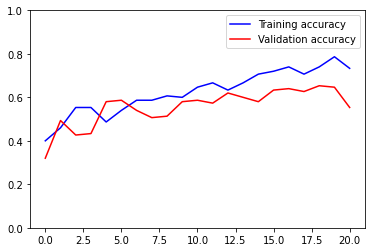

In [ ]:
model = ConvNet(train_dataset[0][0].shape, 3).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

train_acc, valid_acc = train_and_eval(model, train_loader, valid_loader)
plot_accuracy(train_acc, valid_acc)

In [ ]:
stats = Statistics()
testing(model, valid_loader, stats)

print(stats.getConfusionMatrixDataFrame())

#bee category
print("\nbee category:")
matrix = stats.getClassConfusionMatrix(0)
print(matrix)
statistics = stats.getStatistics(matrix)
print(statistics)

#ice cream category
print("\nice cream category:")
matrix = stats.getClassConfusionMatrix(1)
print(matrix)
statistics = stats.getStatistics(matrix)
print(statistics)

#mushroom category
print("\nmushroom category:")
matrix = stats.getClassConfusionMatrix(2)
print(matrix)
statistics = stats.getStatistics(matrix)
print(statistics)

           bee  ice cream  mushroom
bee         36          6         8
ice cream   26         12        12
mushroom    15          0        35

bee category:
{'TP': 36, 'TN': 12, 'FP': 14, 'FN': 41}
{'accuracy': 0.46601941747572817, 'recall': 0.4675324675324675, 'precision': 0.72, 'f1': 0.5669291338582677}

ice cream category:
{'TP': 12, 'TN': 23, 'FP': 38, 'FN': 6}
{'accuracy': 0.4430379746835443, 'recall': 0.6666666666666666, 'precision': 0.24, 'f1': 0.3529411764705882}

mushroom category:
{'TP': 35, 'TN': 32, 'FP': 15, 'FN': 20}
{'accuracy': 0.6568627450980392, 'recall': 0.6363636363636364, 'precision': 0.7, 'f1': 0.6666666666666666}
